In [3]:
import pandas as pd
import networkx as nx
from sklearn.linear_model import LinearRegression
import matplotlib as plt


#local
from homophily_utils import random_sampling, biased_sampling_by_trait, homophily_function, create_group_graph, prepare_regression_data

In [4]:
BASE_WEIGHTS = {
    'age': 0.33,
    'education': 0.33,
    'gender': 0.34  # Sum of weights should be 1
}
plt.figure(figsize=(10, 6))
plt.bar(edit_distance_df['group_id'], edit_distance_df['edit_distance'], color='skyblue')
plt.xlabel('Group ID')
plt.ylabel('Graph Edit Distance')
plt.title('Graph Edit Distance Across Groups')
plt.show()
# Define max distances for traits (binary traits have max distance 1)
MAX_DISTANCES = {
    'age': 1,
    'education': 1,
    'gender': 1
}

SEED = 123
GROUP_SIZE = 10
NUM_GROUPS = 10
GROUP_FORMATION = 'biased' #'random' #
TRAIT_BIAS = 'age+edu+gender' #'age' #'age+edu' # #  
TOLERANCE = 0.01

AttributeError: module 'matplotlib' has no attribute 'figure'

# Data processing

In [ ]:
data = pd.read_csv('binary_age_gender_edu.csv')
#create a trait combination identifier column
if GROUP_FORMATION == 'biased':
    if TRAIT_BIAS == 'age+edu+gender':
        data['trait_combination'] = data.apply(lambda row: f"{row['age']}-{row['education']}-{row['gender']}", axis=1) #group by age+edu+gender
    elif TRAIT_BIAS == 'age+edu':
        data['trait_combination'] = data.apply(lambda row: f"{row['age']}-{row['education']}", axis=1) #group by age+edu
    elif TRAIT_BIAS == 'age':
        data['trait_combination'] = data.apply(lambda row: f"{row['age']}", axis=1) #group by age

    print(data['trait_combination'].value_counts())

print(data.head())
print('\n')

≥35-<HBO-Female      31
≥35-<HBO-Male        24
≥35-HBO/WO-Female    16
≥35-HBO/WO-Male      15
<35-<HBO-Male         5
<35-HBO/WO-Male       3
<35-HBO/WO-Female     3
<35-<HBO-Female       3
Name: trait_combination, dtype: int64
   age  gender education  trait_combination
0  ≥35    Male    HBO/WO    ≥35-HBO/WO-Male
1  ≥35    Male    HBO/WO    ≥35-HBO/WO-Male
2  ≥35    Male    HBO/WO    ≥35-HBO/WO-Male
3  ≥35  Female      <HBO    ≥35-<HBO-Female
4  ≥35  Female    HBO/WO  ≥35-HBO/WO-Female




# Group formation

In [ ]:
if GROUP_FORMATION == 'random':
    grouped_data = random_sampling(
    population_data=data,
    group_size=GROUP_SIZE,
    num_groups=NUM_GROUPS,
    seed=SEED)
elif GROUP_FORMATION == 'biased':
    grouped_data = biased_sampling_by_trait(
        population_data=data,
        group_size=GROUP_SIZE,
        num_groups=NUM_GROUPS,
        trait='trait_combination',  
        seed=SEED  
    )

preview groups

In [ ]:
print(grouped_data[90:100])

    group_id  age  gender education  trait_combination
90        10  ≥35    Male    HBO/WO    ≥35-HBO/WO-Male
91        10  ≥35    Male    HBO/WO    ≥35-HBO/WO-Male
92        10  ≥35    Male    HBO/WO    ≥35-HBO/WO-Male
93        10  <35    Male      <HBO      <35-<HBO-Male
94        10  <35    Male    HBO/WO    <35-HBO/WO-Male
95        10  <35    Male      <HBO      <35-<HBO-Male
96        10  <35    Male      <HBO      <35-<HBO-Male
97        10  <35  Female      <HBO    <35-<HBO-Female
98        10  ≥35  Female    HBO/WO  ≥35-HBO/WO-Female
99        10  <35    Male    HBO/WO    <35-HBO/WO-Male


In [ ]:
if GROUP_FORMATION != 'random':
    #drop the trait_combination column for the graph formation/regression
    grouped_data = grouped_data.drop(columns=['trait_combination'])

In [ ]:
group_graphs = {}

for group_id, support_group_data in grouped_data.groupby('group_id'):
    person_ids = support_group_data.index.tolist()

    G = nx.complete_graph(GROUP_SIZE)

    # Relabel nodes with person IDs
    mapping = {i: person_ids[i] for i in range(GROUP_SIZE)}
    G = nx.relabel_nodes(G, mapping)

    # Assign node attributes
    for person_id, row in support_group_data.iterrows():
        G.nodes[person_id].update(row.to_dict())  # Add attributes to nodes

    for node1, node2 in G.edges():
        weight = homophily_function(node1, node2, G, BASE_WEIGHTS, MAX_DISTANCES)
        G.edges[node1, node2]['weight'] = weight

    group_graphs[group_id] = G

visualize

{(60, 61): Text(-0.11861788674909024, 0.17902550166059433, '1.0'),
 (60, 62): Text(0.017359173964357433, -0.12215833034703538, '1.0'),
 (60, 63): Text(-0.7174479290855086, -0.4412553524000088, '1.0'),
 (60, 64): Text(-0.40729154700455156, -0.15030997345482325, '1.0'),
 (60, 65): Text(-0.8816865153721458, 0.12887859881223465, '1.0'),
 (60, 66): Text(-0.43780665347616643, -0.5750683338353499, '1.0'),
 (60, 67): Text(-0.3876555506124717, 0.39599876376011817, '1.0'),
 (60, 68): Text(-0.6004991887190085, 0.18809935508999415, '1.0'),
 (60, 69): Text(-0.12797460735955135, -0.4352201192047796, '1.0'),
 (61, 62): Text(0.8141464633188016, 0.2648696437933226, '1.0'),
 (61, 63): Text(0.07933936026893551, -0.054227378259650794, '1.0'),
 (61, 64): Text(0.38949574234989254, 0.23671800068553475, '1.0'),
 (61, 65): Text(-0.08489922601770172, 0.5159065729525927, '1.0'),
 (61, 66): Text(0.35898063587827767, -0.18804035969499194, '1.0'),
 (61, 67): Text(0.4091317387419724, 0.7830267379004762, '1.0'),
 (61

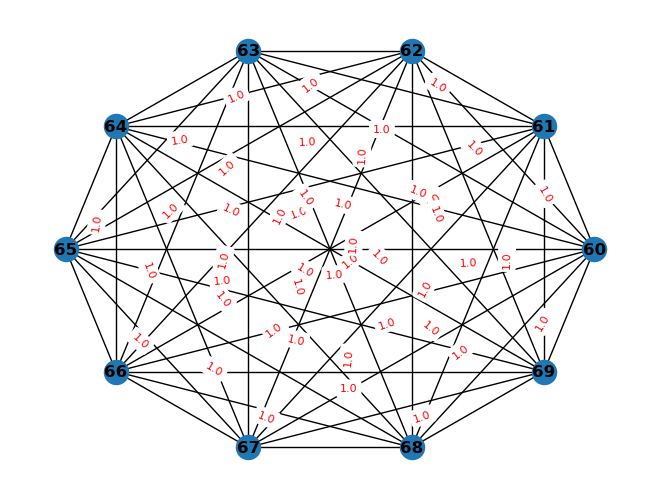

In [ ]:
G = group_graphs[7]
pos=nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G), edge_labels=edge_labels, font_size=8, font_color='red')

# sample_group = group_graphs[3]
# for node, attributes in sample_group.nodes(data=True):
#     print(f"Node {node}: {attributes}")

# Predict

In [ ]:
for group_id, G in group_graphs.items():
    for node1, node2 in G.edges():
        weight = homophily_function(node1, node2, G, BASE_WEIGHTS, MAX_DISTANCES)
        G.edges[node1, node2]['weight'] = weight

# Regression

In [ ]:
attributes = ['age', 'education', 'gender']
recovered_weights_by_group = []

for group_id, G in group_graphs.items():
    regression_data = prepare_regression_data(G, attributes, MAX_DISTANCES)
    
    X = regression_data[attributes]
    Y = regression_data['target']

    model = LinearRegression()
    model.fit(X, Y)

    recovered_weights = pd.Series(model.coef_, index=attributes)
    normalized_recovered_weights = recovered_weights / recovered_weights.sum()  # Normalize weights

    recovered_weights_by_group.append({
    'group_id': group_id,
    'age': normalized_recovered_weights['age'],
    'education': normalized_recovered_weights['education'],
    'gender': normalized_recovered_weights['gender']
    })

recovered_weights_df = pd.DataFrame(recovered_weights_by_group)


Add true weights as a reference

In [ ]:
# Convert BASE_WEIGHTS to a DataFrame row
base_weights_row = pd.DataFrame([{
    'group_id': 'True Weights',  # Label as reference
    'age': BASE_WEIGHTS['age'],
    'education': BASE_WEIGHTS['education'],
    'gender': BASE_WEIGHTS['gender']
}])

# Concatenate BASE_WEIGHTS with recovered weights
final_df = pd.concat([base_weights_row, recovered_weights_df], ignore_index=True)

# Preview the combined DataFrame
print(final_df)


        group_id   age  education  gender
0   True Weights  0.33       0.33    0.34
1              1   NaN        NaN     NaN
2              2   NaN        NaN     NaN
3              3   NaN        NaN     NaN
4              4   NaN        NaN     NaN
5              5  0.33       0.33    0.34
6              6   NaN        NaN     NaN
7              7   NaN        NaN     NaN
8              8   NaN        NaN     NaN
9              9  0.33       0.33    0.34
10            10  0.33       0.33    0.34


# Graph edit distance

In [ ]:
def edge_match(attr1, attr2):
    """Compare edge weights with a tolerance."""
    return abs(attr1['weight'] - attr2['weight']) <= TOLERANCE

In [ ]:
#TODO: deal with NaN weights when recreating the graph